In [1]:
import json
import time

import numpy as np
import pandas as pd

from bs4 import BeautifulSoup

from pydantic import BaseModel
from typing import List, Optional

from selenium import webdriver

from supabase import create_client, Client

import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch, VerticalPitch
import seaborn as sns

In [2]:
driver = webdriver.Chrome()

In [3]:
whoscored_url = 'https://1xbet.whoscored.com/Matches/1866138/Live/Europe-Champions-League-2024-2025-FK-Crvena-Zvezda-Barcelona'

In [4]:
driver.get(whoscored_url)

In [5]:
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [6]:
element = soup.select_one('script:-soup-contains("matchCentreData")')

In [7]:
matchdict = json.loads(element.text.split("matchCentreData: ")[1].split(',\n')[0])

In [8]:
match_events = matchdict['events']

In [9]:
df = pd.DataFrame(match_events)

In [10]:
df.dropna(subset='playerId', inplace=True)

In [11]:
df = df.where(pd.notnull(df), None)

In [12]:
df = df.rename(
    {
        'eventId': 'event_id',
        'expandedMinute': 'expanded_minute',
        'outcomeType': 'outcome_type',
        'isTouch': 'is_touch',
        'playerId': 'player_id',
        'teamId': 'team_id',
        'endX': 'end_x',
        'endY': 'end_y',
        'blockedX': 'blocked_x',
        'blockedY': 'blocked_y',
        'goalMouthZ': 'goal_mouth_z',
        'goalMouthY': 'goal_mouth_y',
        'isShot': 'is_shot',
        'cardType': 'card_type',
        'isGoal': 'is_goal'
    },
    axis=1
)

In [13]:
df['period_display_name'] = df['period'].apply(lambda x: x['displayName'])
df['type_display_name'] = df['type'].apply(lambda x: x['displayName'])
df['outcome_type_display_name'] = df['outcome_type'].apply(lambda x: x['displayName'])

In [14]:
df.drop(columns=["period", "type", "outcome_type"], inplace=True)

In [15]:
if 'is_goal' not in df.columns:
    print('missing goals')
    df['is_goal'] = False

In [16]:
df.head()

,id,event_id,minute,second,team_id,x,y,expanded_minute,qualifiers,satisfiedEventsTypes,...,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,is_goal,card_type,period_display_name,type_display_name,outcome_type_display_name
2,2.745000e+09,3,0,0.0,65,50.2,49.7,0,"[{'type': {'value': 212, 'displayName': 'Lengt...","[91, 117, 30, 35, 37, 216, 218]",...,NaN,NaN,NaN,NaN,None,None,None,FirstHalf,Pass,Successful
3,2.745000e+09,4,0,1.0,65,43.3,54.9,0,"[{'type': {'value': 140, 'displayName': 'PassE...","[91, 117, 30, 35, 37, 216, 218]",...,NaN,NaN,NaN,NaN,None,None,None,FirstHalf,Pass,Successful
4,2.745000e+09,5,0,3.0,65,40.5,63.6,0,"[{'type': {'value': 178, 'displayName': 'Stand...","[91, 117, 30, 35, 38, 216, 218]",...,NaN,NaN,NaN,NaN,None,None,None,FirstHalf,Pass,Successful
5,2.745000e+09,6,0,5.0,65,35.3,43.4,0,"[{'type': {'value': 212, 'displayName': 'Lengt...","[91, 117, 30, 36, 37, 216, 218]",...,NaN,NaN,NaN,NaN,None,None,None,FirstHalf,Pass,Successful
6,2.745000e+09,7,0,8.0,65,36.2,65.8,0,"[{'type': {'value': 178, 'displayName': 'Stand...","[91, 117, 30, 36, 38, 216, 218]",...,NaN,NaN,NaN,NaN,None,None,None,FirstHalf,Pass,Successful


selected = df[['minute','second']]

In [19]:
selected = df[['minute','second', 'player_id', 'type_display_name', 'outcome_type_display_name', 'x', 'y', 'end_x', 'end_y']]

In [20]:
selected

,minute,second,player_id,type_display_name,outcome_type_display_name,x,y,end_x,end_y
2,0,0.0,402197.0,Pass,Successful,50.2,49.7,43.3,54.9
3,0,1.0,454343.0,Pass,Successful,43.3,54.9,40.5,63.6
4,0,3.0,279423.0,Pass,Successful,40.5,63.6,35.0,42.2
5,0,5.0,498386.0,Pass,Successful,35.3,43.4,36.7,65.8
6,0,8.0,106885.0,Pass,Successful,36.2,65.8,37.8,40.6
...,...,...,...,...,...,...,...,...,...
1513,95,38.0,422937.0,Challenge,Unsuccessful,30.2,90.2,NaN,NaN
1514,95,41.0,402097.0,OffsidePass,Successful,70.5,15.8,79.3,3.1
1515,95,41.0,106885.0,OffsideProvoked,Successful,23.5,86.9,NaN,NaN
1516,95,59.0,106885.0,Pass,Successful,22.0,84.8,30.5,64.3


In [25]:
#filtered = selected[selected['player_id'] == 106885 and selected['type_display_name'] == 'Pass']

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [47]:
filtered = selected[selected['player_id'] == 106885]

In [48]:
filtered

,minute,second,player_id,type_display_name,outcome_type_display_name,x,y,end_x,end_y
6,0,8.0,106885.0,Pass,Successful,36.2,65.8,37.8,40.6
33,1,19.0,106885.0,Pass,Successful,46.1,67.2,62.7,95.4
35,1,27.0,106885.0,Pass,Successful,46.4,76.4,49.3,42.7
45,1,54.0,106885.0,Pass,Successful,68.3,77.9,75.4,94.1
54,2,30.0,106885.0,BallTouch,Successful,67.8,95.9,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1476,93,18.0,106885.0,Pass,Successful,57.0,70.3,61.1,83.0
1488,94,19.0,106885.0,Pass,Successful,25.6,76.5,32.2,66.4
1490,94,23.0,106885.0,Pass,Successful,29.5,74.4,35.9,62.3
1515,95,41.0,106885.0,OffsideProvoked,Successful,23.5,86.9,NaN,NaN


In [49]:
final = filtered[filtered['type_display_name'] == 'Pass']

In [50]:
final

,minute,second,player_id,type_display_name,outcome_type_display_name,x,y,end_x,end_y
6,0,8.0,106885.0,Pass,Successful,36.2,65.8,37.8,40.6
33,1,19.0,106885.0,Pass,Successful,46.1,67.2,62.7,95.4
35,1,27.0,106885.0,Pass,Successful,46.4,76.4,49.3,42.7
45,1,54.0,106885.0,Pass,Successful,68.3,77.9,75.4,94.1
76,4,17.0,106885.0,Pass,Successful,47.7,76.3,67.7,14.9
...,...,...,...,...,...,...,...,...,...
1474,93,11.0,106885.0,Pass,Successful,56.7,69.1,62.0,57.2
1476,93,18.0,106885.0,Pass,Successful,57.0,70.3,61.1,83.0
1488,94,19.0,106885.0,Pass,Successful,25.6,76.5,32.2,66.4
1490,94,23.0,106885.0,Pass,Successful,29.5,74.4,35.9,62.3


In [58]:
final['x'] = final['x']*1.2
final['end_x'] = final['end_x']*1.2

final['y'] = final['y']*0.8
final['end_y'] = final['end_y']*0.8

C:\Users\risha\AppData\Local\Temp\ipykernel_8348\1497007985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['x'] = final['x']*1.2
C:\Users\risha\AppData\Local\Temp\ipykernel_8348\1497007985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['end_x'] = final['end_x']*1.2
C:\Users\risha\AppData\Local\Temp\ipykernel_8348\1497007985.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [52]:
final

,minute,second,player_id,type_display_name,outcome_type_display_name,x,y,end_x,end_y
6,0,8.0,106885.0,Pass,Successful,36.2,65.8,37.8,40.6
33,1,19.0,106885.0,Pass,Successful,46.1,67.2,62.7,95.4
35,1,27.0,106885.0,Pass,Successful,46.4,76.4,49.3,42.7
45,1,54.0,106885.0,Pass,Successful,68.3,77.9,75.4,94.1
76,4,17.0,106885.0,Pass,Successful,47.7,76.3,67.7,14.9
...,...,...,...,...,...,...,...,...,...
1474,93,11.0,106885.0,Pass,Successful,56.7,69.1,62.0,57.2
1476,93,18.0,106885.0,Pass,Successful,57.0,70.3,61.1,83.0
1488,94,19.0,106885.0,Pass,Successful,25.6,76.5,32.2,66.4
1490,94,23.0,106885.0,Pass,Successful,29.5,74.4,35.9,62.3


In [59]:
final_successful = final[final['outcome_type_display_name'] == 'Successful']

In [60]:
final_successful

,minute,second,player_id,type_display_name,outcome_type_display_name,x,y,end_x,end_y
6,0,8.0,106885.0,Pass,Successful,43.44,52.64,45.36,32.48
33,1,19.0,106885.0,Pass,Successful,55.32,53.76,75.24,76.32
35,1,27.0,106885.0,Pass,Successful,55.68,61.12,59.16,34.16
45,1,54.0,106885.0,Pass,Successful,81.96,62.32,90.48,75.28
76,4,17.0,106885.0,Pass,Successful,57.24,61.04,81.24,11.92
...,...,...,...,...,...,...,...,...,...
1474,93,11.0,106885.0,Pass,Successful,68.04,55.28,74.40,45.76
1476,93,18.0,106885.0,Pass,Successful,68.40,56.24,73.32,66.40
1488,94,19.0,106885.0,Pass,Successful,30.72,61.20,38.64,53.12
1490,94,23.0,106885.0,Pass,Successful,35.40,59.52,43.08,49.84


In [61]:
final_unsuccessful = final[final['outcome_type_display_name'] == 'Unsuccessful']

In [62]:
final_unsuccessful

,minute,second,player_id,type_display_name,outcome_type_display_name,x,y,end_x,end_y
86,4,47.0,106885.0,Pass,Unsuccessful,72.72,59.36,85.68,76.00
115,6,7.0,106885.0,Pass,Unsuccessful,70.56,56.48,103.08,60.08
237,10,46.0,106885.0,Pass,Unsuccessful,73.08,36.40,94.44,8.72
459,28,0.0,106885.0,Pass,Unsuccessful,75.60,75.12,77.64,74.56
719,44,58.0,106885.0,Pass,Unsuccessful,41.28,60.72,46.20,55.92
1367,87,30.0,106885.0,Pass,Unsuccessful,35.28,78.72,38.04,78.24


(0.0, 80.0)

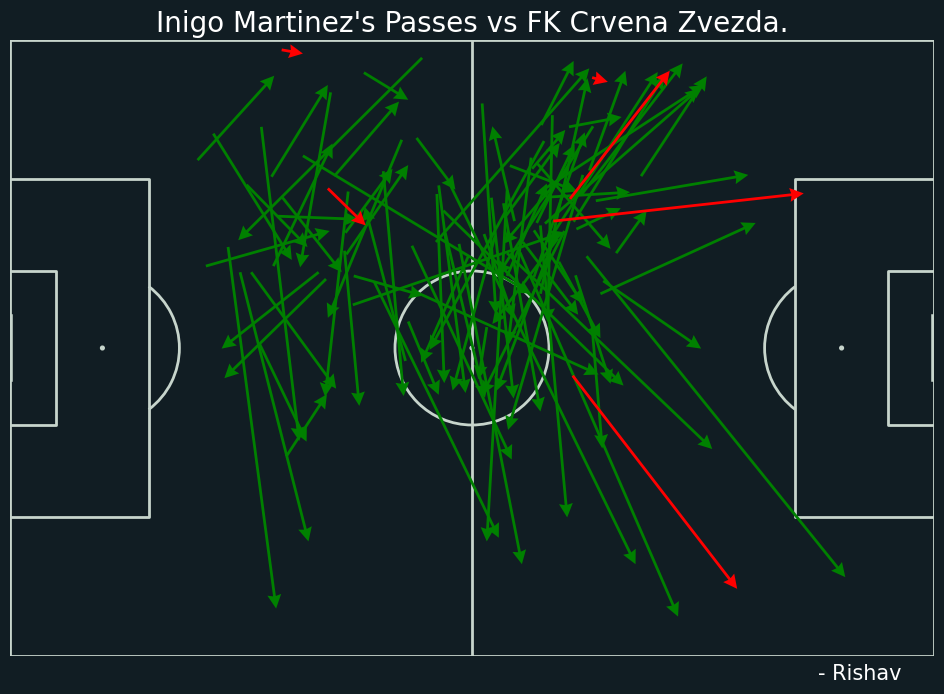

In [89]:
pitch = Pitch(pitch_type='statsbomb',
                      pitch_color='#111d23', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(13.5,8), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#111d23')

plt.gca().invert_yaxis()

pitch.arrows(final_successful.x, final_successful.y, final_successful.end_x, final_successful.end_y, width=2,
             headwidth=5, headlength=5, color='green', ax=ax, label='Completed Passes')

pitch.arrows(final_unsuccessful.x, final_unsuccessful.y, final_unsuccessful.end_x, final_unsuccessful.end_y, width=2,
             headwidth=5, headlength=5, color='red', ax=ax, label='Completed Passes')


plt.title("Inigo Martinez's Passes vs FK Crvena Zvezda.", fontsize = 20, c = 'w')

endnote = "- Rishav"
plt.figtext(0.8, 0.1, endnote, ha="center", va="top", fontsize=15, color="white")

plt.xlim(0,120)
plt.ylim(0,80)